In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision import *

In [3]:
from utility import *

In [8]:
path = Path('/home/jupyter/.fastai/data/humpback')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/humpback/validation_random.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train'),
 PosixPath('/home/jupyter/.fastai/data/humpback/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/models')]

In [10]:
df_train = preprocess(path/'train.csv')
df_train.head()

,Image,Id,is_valid
0,0000e88ab.jpg,w_f48451c,False
1,0001f9222.jpg,w_c3d896a,True
2,00029d126.jpg,w_20df2c5,True
3,00050a15a.jpg,new_whale,False
4,0005c1ef8.jpg,new_whale,False


In [13]:
(df_train.Id!='new_whale').mean()

0.6189424707227633

In [46]:
df_train['new_whale'] = df_train.Id == 'new_whale'

In [47]:
df_train.head()

,Image,Id,is_valid,new_whale
0,0000e88ab.jpg,w_f48451c,False,False
1,0001f9222.jpg,w_c3d896a,True,False
2,00029d126.jpg,w_20df2c5,True,False
3,00050a15a.jpg,new_whale,False,True
4,0005c1ef8.jpg,new_whale,False,True


In [48]:
(df_train.is_valid==True).mean() #17% validation

0.17306099917195694

# End of preprocessing

In [49]:
src = (ImageList
       .from_df(df_train,path=path,folder='train')
       .split_from_df(col = 2)
       .label_from_df(cols = 3, label_cls = CategoryList)
      )

In [50]:
data = (src
       .add_test_folder('test')
       .transform(get_transforms(max_zoom=1,max_warp=0),size=224,resize_method=ResizeMethod.SQUISH)
       .databunch()
       .normalize(imagenet_stats))

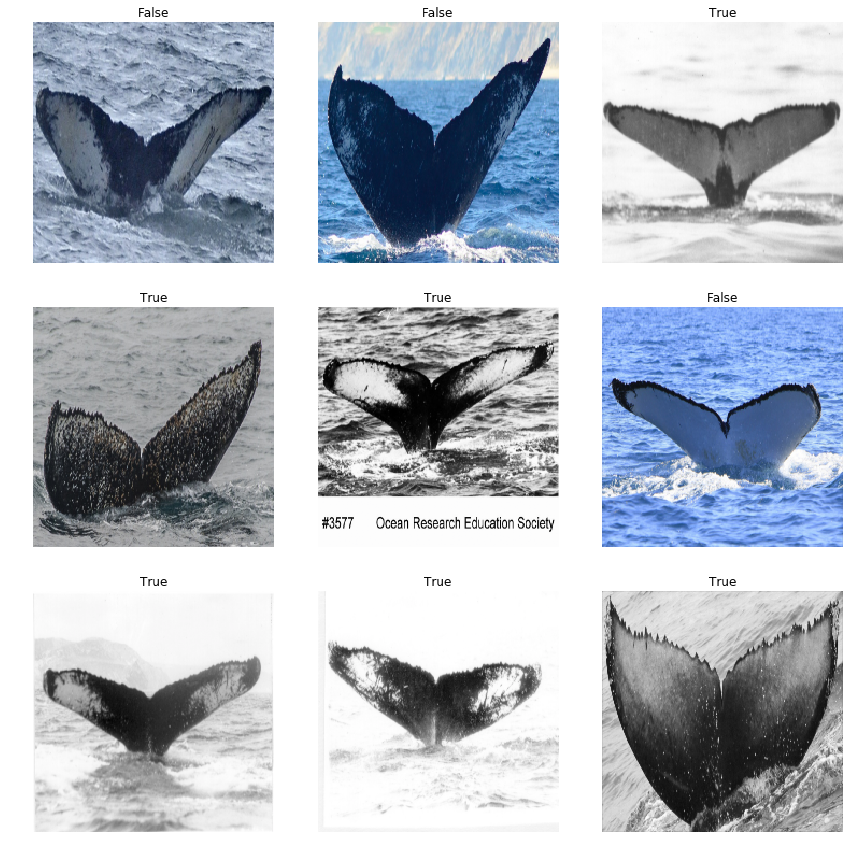

In [52]:
data.show_batch(rows=3,ds_type=DatasetType.Valid)

problem 1. Text in pic

problem 2. black white v.s RGB

In [55]:
learn = create_cnn(data,models.resnet50,metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


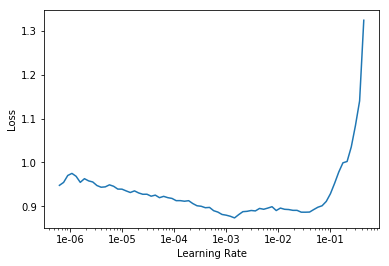

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
lr = 2e-4

In [59]:
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.733728,0.586199,0.704489,03:48
2,0.637895,0.551010,0.732969,03:42
3,0.584405,0.530391,0.739804,03:41
4,0.575582,0.526322,0.741171,03:42


In [60]:
learn.save('resnet50-224-stage-1')

In [62]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


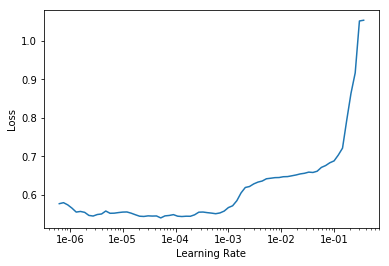

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
1,0.553010,0.517173,0.751880,04:43
2,0.529509,0.498275,0.761677,04:45
3,0.495962,0.480252,0.774664,04:45
4,0.463039,0.467699,0.781727,04:45
5,0.427803,0.469385,0.780132,04:47


In [65]:
learn.save('resnet50-224-stage-2')

In [67]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [79]:
preds[0].shape

torch.Size([7960, 2])

In [80]:
pred = torch.argmax(preds[0],dim=1)

In [84]:
result = pred.numpy()
result.shape

(7960,)

In [85]:
np.count_nonzero(result)

2439

In [91]:
df_test = pd.read_csv(path/'sample_submission.csv')

In [93]:
df_test.head()

,Image,Id
0,00028a005.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1,000dcf7d8.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
2,000e7c7df.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
3,0019c34f4.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
4,001a4d292.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


In [114]:
data.test_ds.items[0]

PosixPath('/home/jupyter/.fastai/data/humpback/test/8fe153df5.jpg')

In [115]:
data.test_ds.x.items[0]

PosixPath('/home/jupyter/.fastai/data/humpback/test/8fe153df5.jpg')

In [116]:
sub = pd.DataFrame({'Image':[path.name for path in data.test_ds.items]})

In [118]:
sub.head()

,Image
0,8fe153df5.jpg
1,a0f38fccb.jpg
2,65a1c41f2.jpg
3,acc799677.jpg
4,7ed205c6c.jpg


In [150]:
result_class = []
for r in result:
    if r == 1:
        result_class.append('new_whale')
    else:
        result_class.append('known_whale')

In [152]:
sub.Id = result_class

In [153]:
sub.head()

,Image,Id
0,8fe153df5.jpg,new_whale
1,a0f38fccb.jpg,new_whale
2,65a1c41f2.jpg,known_whale
3,acc799677.jpg,new_whale
4,7ed205c6c.jpg,known_whale


In [154]:
sub.to_csv('new_whale_detector.csv',index=False)